In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import ast

In [2]:
os.chdir('..')

In [3]:
def string_to_matrix(matrix_str):
    matrix_list = ast.literal_eval(matrix_str)
    return np.array(matrix_list)

def folds_to_ranks(folds):
    matrix_list = folds['lists'].tolist()
    matrix_stack = np.stack(matrix_list, axis=0)
    arr = np.mean(matrix_stack, axis=0)

    rank_epoch_accuracy = np.argsort(-arr.T[0])
    rank_epoch_overall = np.argsort(-arr.sum(axis=1))

    accuracy = arr[rank_epoch_accuracy[0]][0]
    listing = arr[rank_epoch_overall[0]]
    metric = sum(listing)
    listing = arr[rank_epoch_overall[0]]

    return rank_epoch_accuracy, rank_epoch_overall, accuracy, metric, listing

def agglomerate_folds(df):
    for i in range(len(df)//5):
        folds = df.iloc[5*i:5*(i+1),:]
        param_names = folds.iloc[0,:-2].index.tolist()
        params = folds.iloc[0,:-2].tolist()

        rank_epoch_accuracy, rank_epoch_overall, accuracy, metric, listing = folds_to_ranks(folds)

        params.append(accuracy)
        param_names.append('best_accuracy')
        params.append(metric)
        param_names.append('best_metric')

        for j in range(3):
            params.append(rank_epoch_accuracy[j])
            param_names.append(f'#{j+1}_epoch_acc')
            params.append(rank_epoch_overall[j])
            param_names.append(f'#{j+1}_epoch_ovr')

        if i == 0:
            out_df = pd.DataFrame(columns=param_names)
        
        params.append(listing)
        param_names.append('dist_details')

        new_row = pd.DataFrame([params], columns=param_names)
        out_df = pd.concat([out_df, new_row], ignore_index=True)
    return out_df


In [4]:
def df_to_i_feature(df, feature):
    totes = len(df)
    variations = len(set(df[feature]))
    f_df = df[[feature, 'best_accuracy', 'best_metric']].copy()
    f_df['config'] = [k for k in range(totes//variations)]*variations
    pivot_acc_df = f_df.pivot(index="config", columns=feature, values="best_accuracy")
    pivot_met_df = f_df.pivot(index="config", columns=feature, values="best_metric")

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pivot_acc_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f'Heatmap of {feature} (Accuracy)')
    sns.heatmap(pivot_met_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f'Heatmap of {feature} (Metric)')

    plt.show()

    f_ans = f_df.groupby(feature).mean()
    best_f_val = f_ans.index[np.argmax(f_ans.best_accuracy)]
    display(f_ans)

    return best_f_val


def df_to_xy_features(df, feature_x, feature_y):
    f_df = df[[feature_x, feature_y, 'best_accuracy', 'best_metric']].copy()
    pivot_acc_df = f_df.pivot(index=feature_x, columns=feature_y, values="best_accuracy")
    pivot_met_df = f_df.pivot(index=feature_x, columns=feature_y, values="best_metric")

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    sns.heatmap(pivot_acc_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f'Heatmap of {feature_x} vs {feature_y} (Accuracy)')
    sns.heatmap(pivot_met_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f'Heatmap of {feature_x} vs {feature_y} (Metric)')

    plt.show()

    layer_ans = f_df.groupby(feature_x).mean()
    best_x_val = layer_ans.index[np.argmax(layer_ans.best_accuracy)]
    display(layer_ans)

    alpha_ans = f_df.groupby(feature_y).mean()
    best_y_val = alpha_ans.index[np.argmax(alpha_ans.best_accuracy)]
    display(alpha_ans)

    return best_x_val, best_y_val

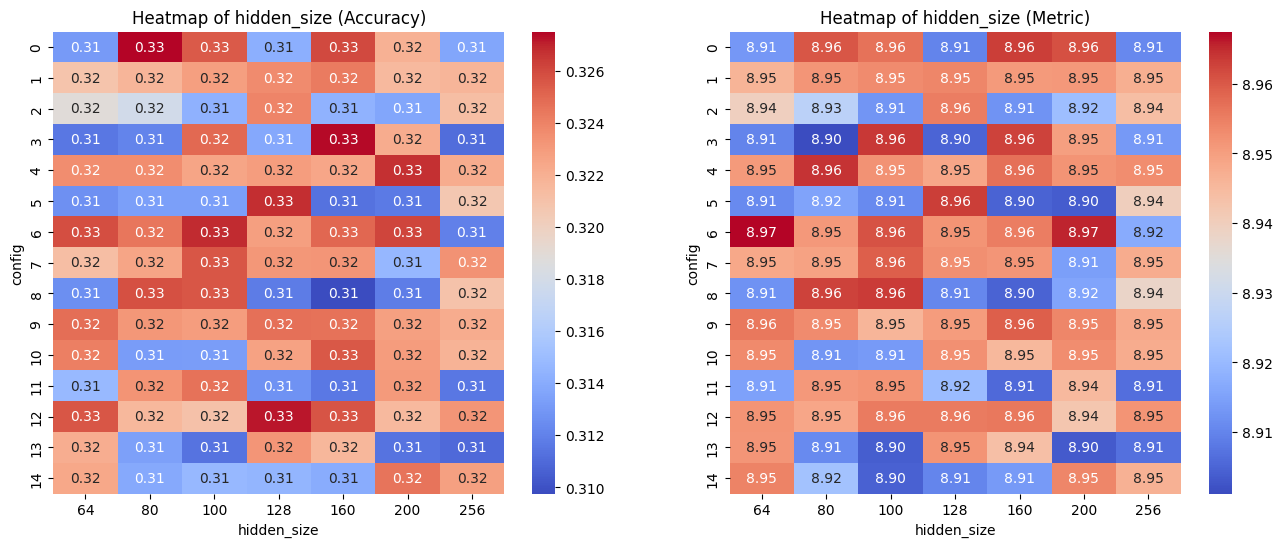

,best_accuracy,best_metric,config
hidden_size,,,
64,0.319605,8.938706,7.0
80,0.319826,8.938708,7.0
100,0.320615,8.940511,7.0
128,0.320538,8.939399,7.0
160,0.320461,8.939071,7.0
200,0.319760,8.939003,7.0
256,0.318625,8.934522,7.0


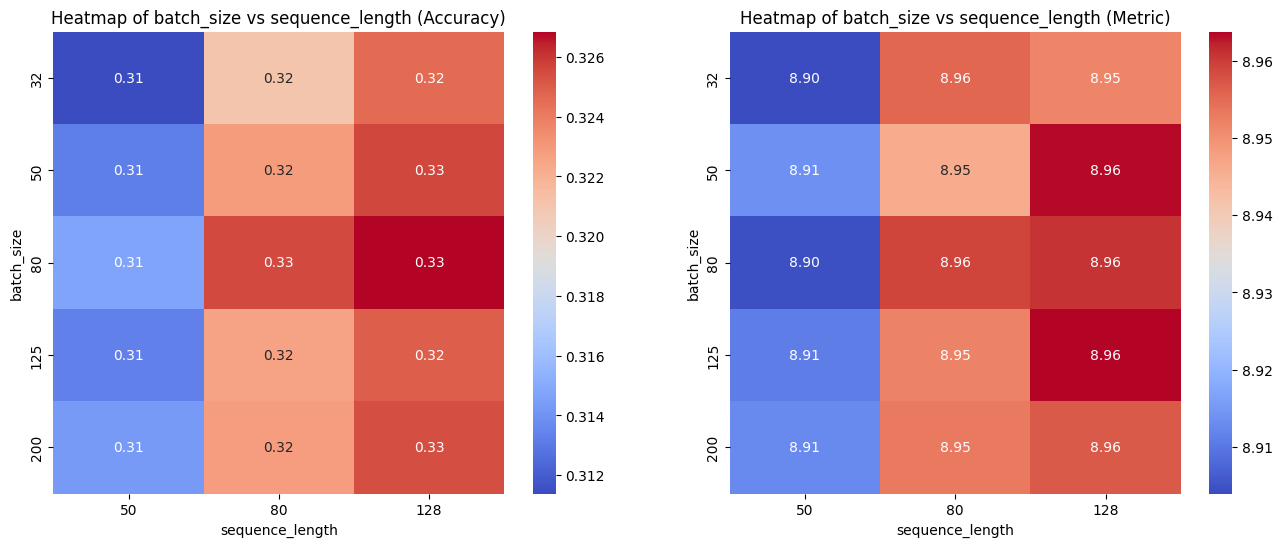

,sequence_length,best_accuracy,best_metric
batch_size,,,
32,86.0,0.318990,8.937070
50,86.0,0.320570,8.940983
80,86.0,0.322387,8.941467
125,86.0,0.320270,8.942207
200,86.0,0.320860,8.940827


,batch_size,best_accuracy,best_metric
sequence_length,,,
50,97.4,0.313390,8.909106
80,97.4,0.322966,8.953138
128,97.4,0.325490,8.959288


hidden_size: 100
batch_size: 80
sequence_length: 128


In [11]:
tuning_results_path = 'hyperparameter_tuning_results_0217_loads.csv'
feature = 'hidden_size'
feature_x = 'batch_size'
feature_y = 'sequence_length'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [16]:
select_df[select_df['sequence_length']==128]

,decay,dropout_rate,alpha_value,hidden_size,num_layers,learning_rate,batch_size,sequence_length,best_accuracy,best_metric,#1_epoch_acc,#1_epoch_ovr,#2_epoch_acc,#2_epoch_ovr,#3_epoch_acc,#3_epoch_ovr,dist_details
44,0.00001,0.25,0.8,100,2,0.001,200,128,0.32544,8.95676,30,30,31,25,23,28,"[0.32544, 0.7437800000000001, 0.91795999999999..."
41,0.00001,0.25,0.8,100,2,0.001,125,128,0.32495,8.96377,25,30,27,25,28,28,"[0.32361000000000006, 0.7485999999999999, 0.92..."
38,0.00001,0.25,0.8,100,2,0.001,80,128,0.32685,8.96078,25,18,18,25,19,19,"[0.32661999999999997, 0.7421, 0.92060000000000..."
35,0.00001,0.25,0.8,100,2,0.001,50,128,0.32561,8.96340,17,17,19,14,15,20,"[0.32561, 0.74749, 0.9196300000000001, 0.9779,..."
32,0.00001,0.25,0.8,100,2,0.001,32,128,0.32460,8.95173,18,11,15,15,12,18,"[0.32167, 0.74071, 0.91794, 0.9779499999999999..."


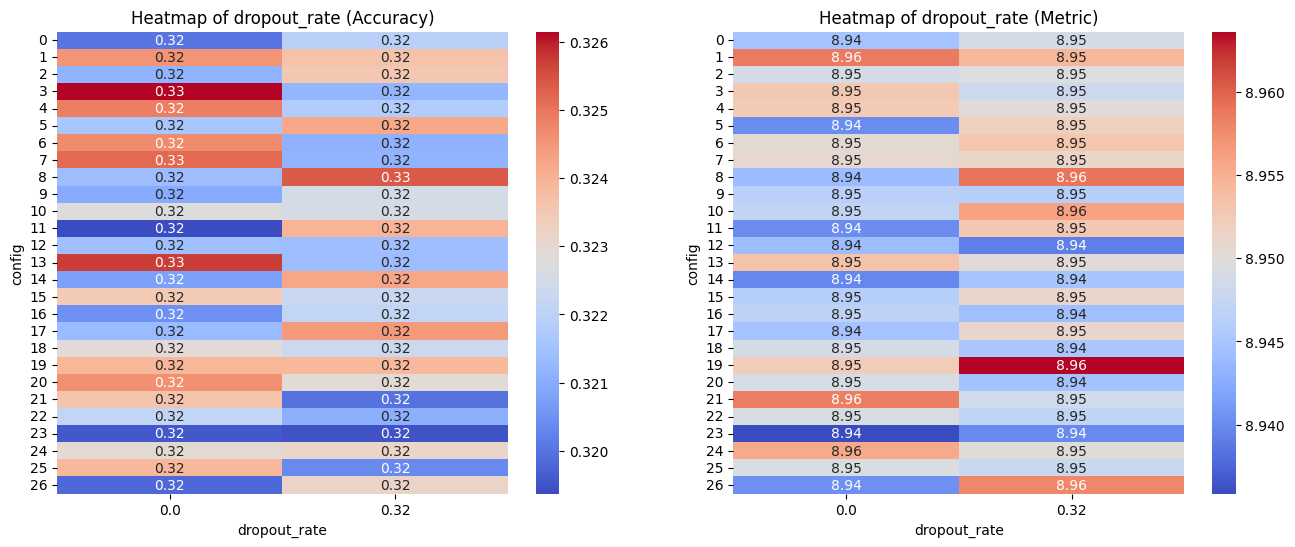

,best_accuracy,best_metric,config
dropout_rate,,,
0.00,0.322563,8.947783,13.0
0.32,0.322415,8.949849,13.0


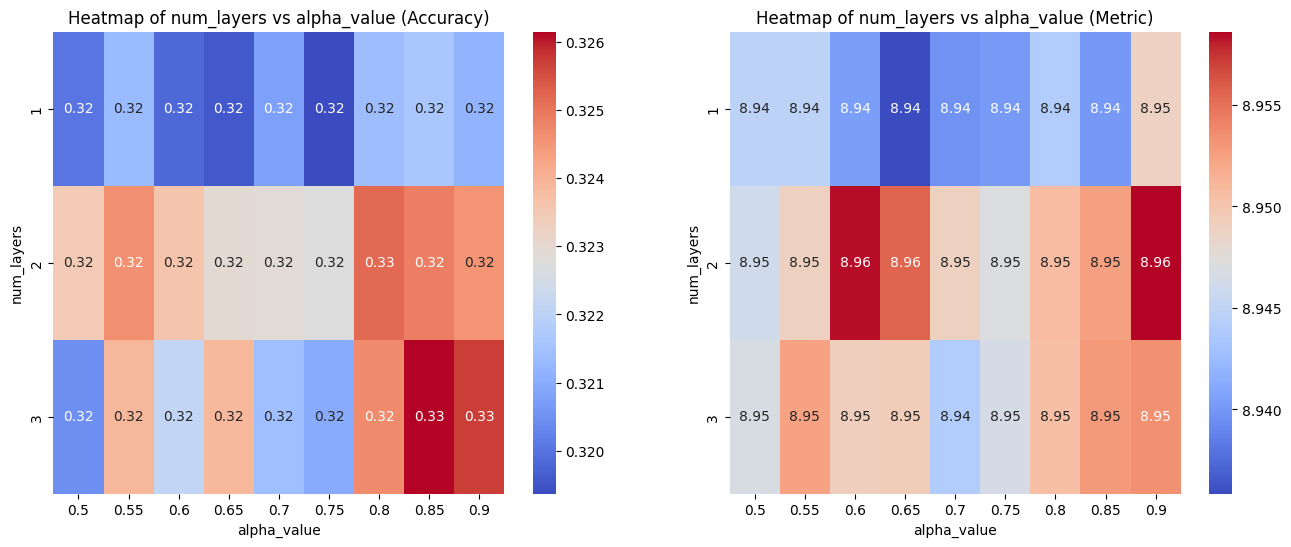

,alpha_value,best_accuracy,best_metric
num_layers,,,
1,0.7,0.320557,8.942048
2,0.7,0.323873,8.951872
3,0.7,0.323258,8.949428


,num_layers,best_accuracy,best_metric
alpha_value,,,
0.50,2.0,0.321320,8.945850
0.55,2.0,0.323277,8.948693
0.60,2.0,0.321857,8.949307
0.65,2.0,0.322123,8.946923
0.70,2.0,0.321680,8.944200
0.75,2.0,0.321037,8.944583
0.80,2.0,0.323747,8.948397
0.85,2.0,0.324220,8.948487
0.90,2.0,0.323803,8.953603


dropout_rate: 0.0
num_layers: 2
alpha_value: 0.85


In [6]:
tuning_results_path = 'hyperparameter_tuning_results_lay_a_drop.csv'
feature = 'dropout_rate'
feature_x = 'num_layers'
feature_y = 'alpha_value'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

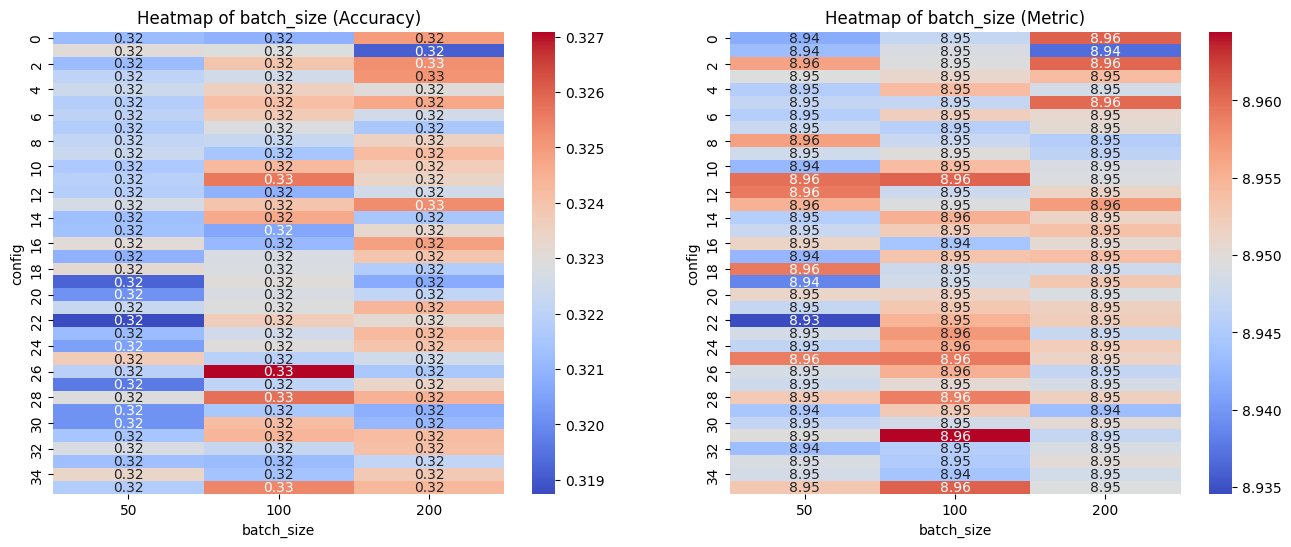

,best_accuracy,best_metric,config
batch_size,,,
50,0.321635,8.948699,17.5
100,0.323060,8.951691,17.5
200,0.323200,8.950500,17.5


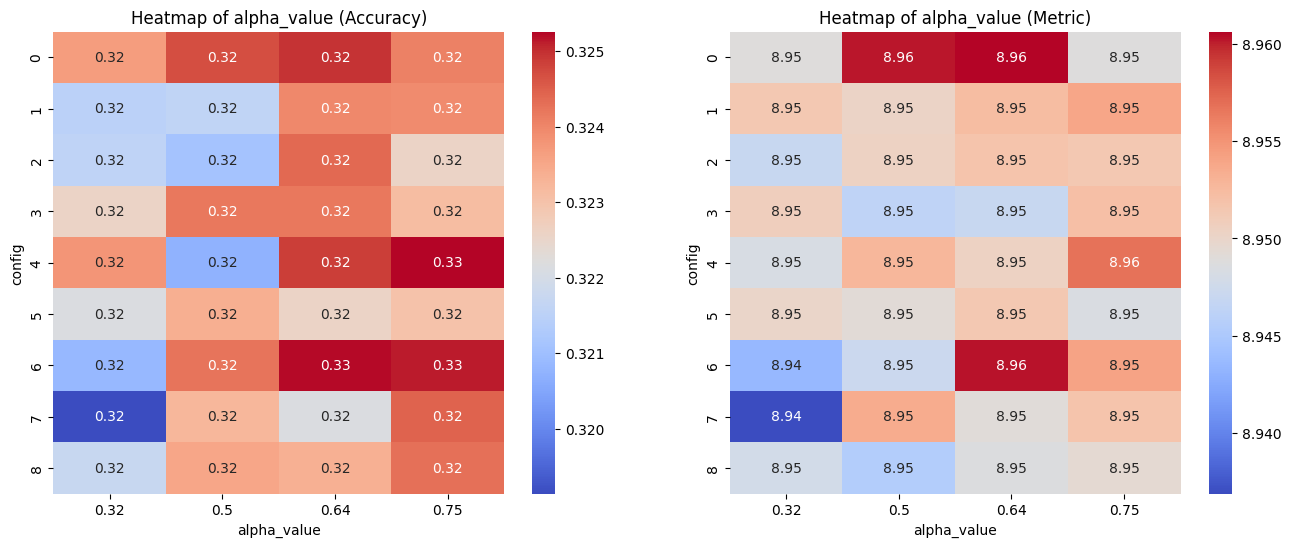

,best_accuracy,best_metric,config
alpha_value,,,
0.32,0.321886,8.947166,4.0
0.50,0.322967,8.950598,4.0
0.64,0.323962,8.952382,4.0
0.75,0.323984,8.951854,4.0


C:\Users\Jim\AppData\Local\Temp\ipykernel_18384\3919820641.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  select_df = select_df[out_df[feature_2]==best_f_val_2]


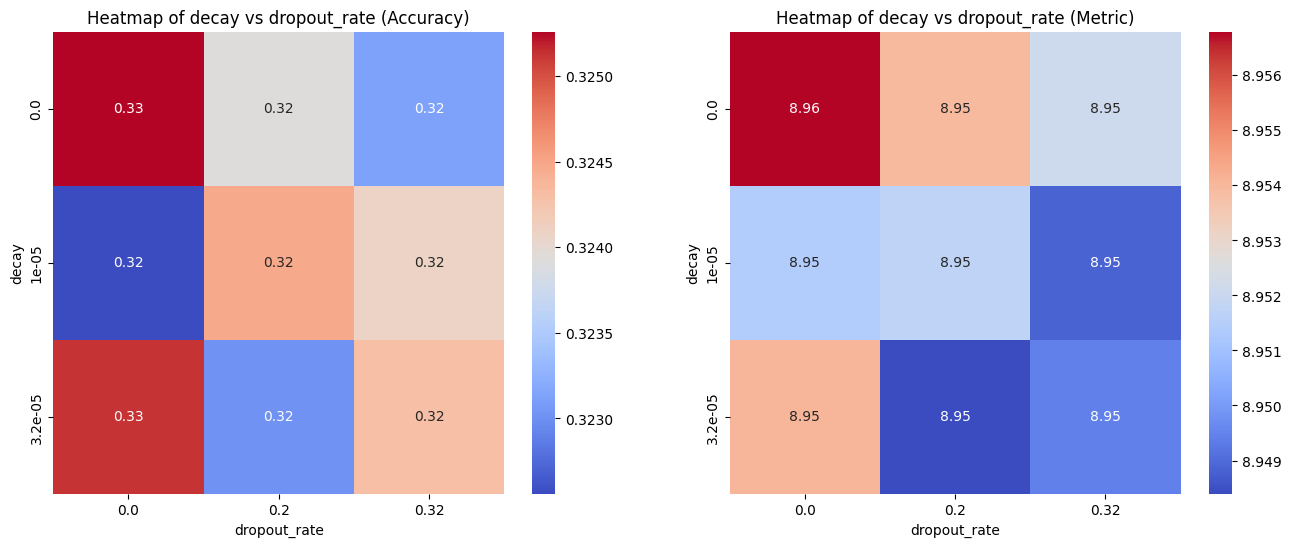

,dropout_rate,best_accuracy,best_metric
decay,,,
0.000000,0.173333,0.324103,8.954280
0.000010,0.173333,0.323703,8.950657
0.000032,0.173333,0.324147,8.950627


,decay,best_accuracy,best_metric
dropout_rate,,,
0.00,0.000014,0.324317,8.954083
0.20,0.000014,0.323803,8.951353
0.32,0.000014,0.323833,8.950127


batch_size: 200
alpha_value: 0.75
decay: 3.2e-05
dropout_rate: 0.0


In [7]:
tuning_results_path = 'hyperparameter_tuning_results_batch_a_drop_dec.csv'
feature = 'batch_size'
feature_2 = 'alpha_value'
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df).sort_values(by=feature)

best_f_val = df_to_i_feature(out_df, feature)
select_df = out_df[out_df[feature]==best_f_val].sort_values(by=feature_2)

best_f_val_2 = df_to_i_feature(select_df, feature_2)
select_df = select_df[out_df[feature_2]==best_f_val_2]

best_x_val, best_y_val = df_to_xy_features(select_df, feature_x, feature_y)

print(f'{feature}: {best_f_val}')
print(f'{feature_2}: {best_f_val_2}')
print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

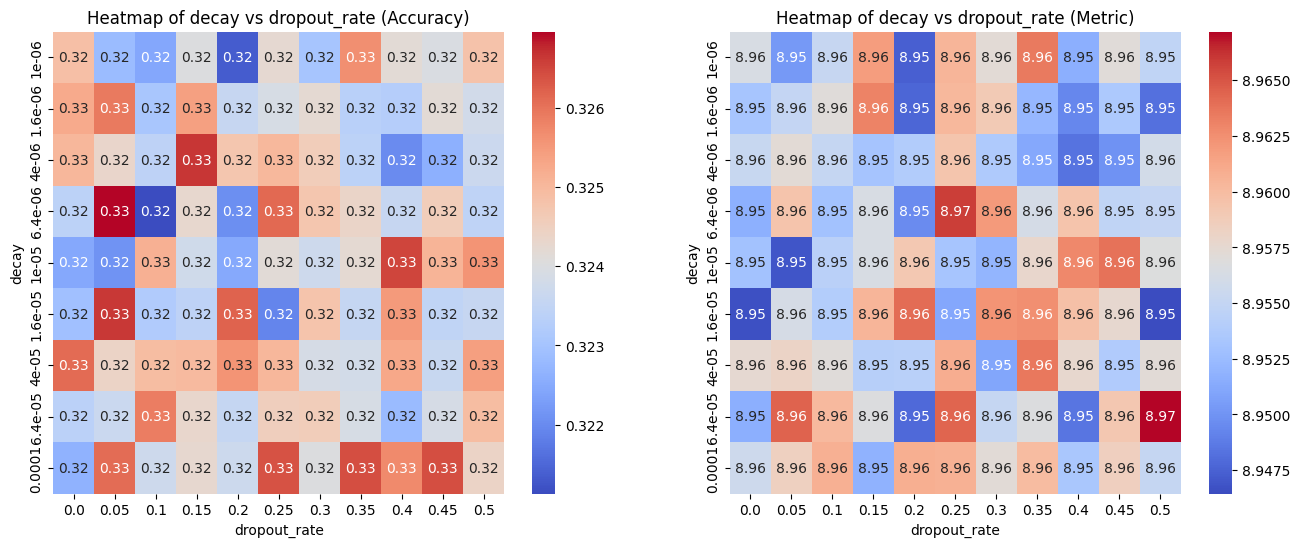

,dropout_rate,best_accuracy,best_metric
decay,,,
0.000001,0.25,0.323761,8.955959
0.000002,0.25,0.324169,8.954396
0.000004,0.25,0.324134,8.953912
0.000006,0.25,0.324065,8.956639
0.000010,0.25,0.324114,8.956017
0.000016,0.25,0.324104,8.956438
0.000040,0.25,0.324817,8.956846
0.000064,0.25,0.324125,8.957440
0.000100,0.25,0.324885,8.957469


,decay,best_accuracy,best_metric
dropout_rate,,,
0.00,0.000027,0.324007,8.953421
0.05,0.000027,0.324767,8.956234
0.10,0.000027,0.323658,8.956261
0.15,0.000027,0.324568,8.957101
0.20,0.000027,0.323692,8.953862
0.25,0.000027,0.324588,8.959570
0.30,0.000027,0.324169,8.956612
0.35,0.000027,0.324297,8.958166
0.40,0.000027,0.324314,8.954532


decay: 0.0001
dropout_rate: 0.05


In [17]:
tuning_results_path = 'hyperparameter_tuning_results_0217_reg.csv'
feature_x = 'decay'
feature_y = 'dropout_rate'

df = pd.read_csv(tuning_results_path)
df['lists'] = df['lists'].apply(string_to_matrix)
out_df = agglomerate_folds(df)

best_x_val, best_y_val = df_to_xy_features(out_df, feature_x, feature_y)

print(f'{feature_x}: {best_x_val}')
print(f'{feature_y}: {best_y_val}')

In [10]:
tops = 20

best_acc_ind = np.argsort(out_df.best_accuracy).tolist()[-tops:]
print(best_acc_ind)
#display(out_df.iloc[best_acc_ind,:])

best_ovr_ind = np.argsort(out_df.best_metric).tolist()[-tops:]
print(best_ovr_ind)
#display(out_df.iloc[best_ovr_ind,:])

reg_df = out_df[['decay','dropout_rate','best_accuracy','best_metric']]
reg_df.iloc[list(set(best_ovr_ind).intersection(set(best_acc_ind)))]

[14, 76, 63, 54, 70, 7, 96, 79, 12, 89, 66, 38, 59, 93, 97, 95, 52, 56, 25, 34]
[5, 58, 93, 90, 92, 71, 3, 39, 61, 62, 52, 14, 7, 73, 53, 59, 82, 78, 38, 87]


,decay,dropout_rate,best_accuracy,best_metric
38,0.000006,0.25,0.32612,8.96585
7,0.000001,0.35,0.32566,8.96352
14,0.000002,0.15,0.32540,8.96306
52,0.000010,0.40,0.32652,8.96286
59,0.000016,0.20,0.32620,8.96409
93,0.000100,0.25,0.32638,8.96064
